# PCA based spike sorting
#### Run the following cells, one by one, and in the written order


In [1]:
# import OpenEphys
import Kwik
from matplotlib import pyplot as plt
import numpy as np
import scipy.signal
import scipy.fftpack

In [2]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

### Enter the file name here:

In [3]:
f_name = '/mnt/data/temp/kaveh/openEphys_data/2018-11-30_16-51-46/experiment1_101.raw.kwd'

In [4]:

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = scipy.signal.butter(order, [low, high], btype='band')
    y = scipy.signal.lfilter(b, a, data)
    return y


In [5]:
file_content = Kwik.load(f_name)


In [6]:
# Band pass filtering
voltage = np.transpose(file_content['data'])[0:4,:]
voltage = butter_bandpass_filter(voltage, 300, 3000, 30000)
dt = 1.0/file_content['info']['sample_rate']
voltage.shape

(4, 6251100)

In [7]:
# Common average referencing

voltage_mean = np.mean(voltage, axis = 0)
voltage = voltage - voltage_mean

## Plot channel data:

<IPython.core.display.Javascript object>


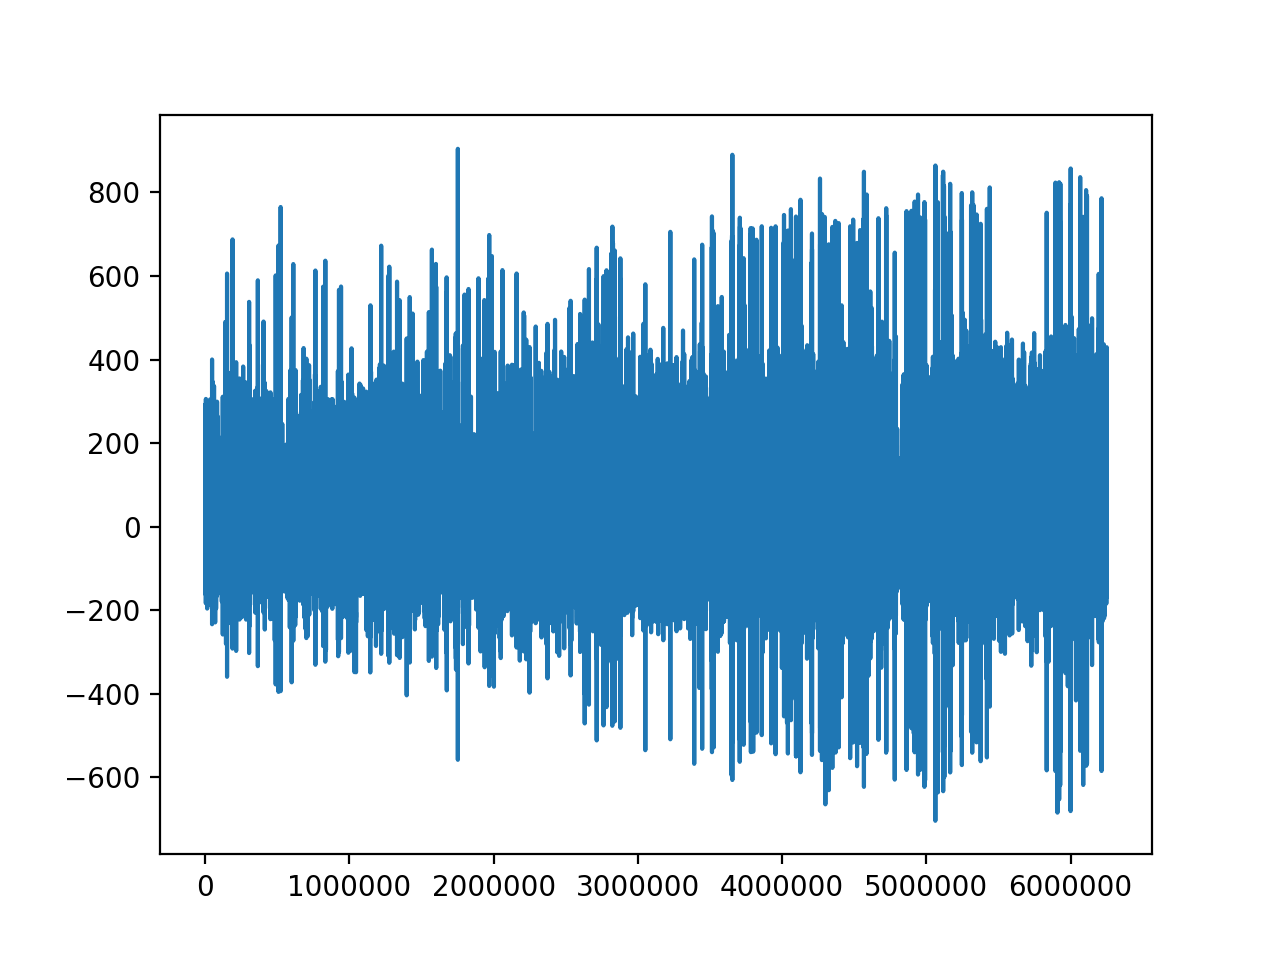

In [8]:
Channel_number =0
ch = voltage[2,:]

plt.figure()
plt.plot(ch)

## Choose threshold:

In [9]:
# spike detection (thresholding)
thresh = 400
spike_indices = np.where(ch>thresh)[0]
peak_times,_ = scipy.signal.find_peaks(ch[spike_indices])
spike_indices = spike_indices[peak_times]


## Choose spike wavelet window length:

In [10]:
pre_window = 0.0005 #s
post_window = 0.001 #s

# align spikes to their peaks

to_exclude = []
pre_index = int(np.round(pre_window / dt))
post_index = int(np.round(post_window / dt))

signal_size = ch.size

aligned_spikes = np.array([ch[i - pre_index : i + post_index ] 
    for i in spike_indices if i not in to_exclude if (i + post_index) < signal_size
        if (i - pre_index) >= 0])


In [11]:
# pca
from sklearn.decomposition import PCA

num_comp = 2
pca = PCA(n_components = num_comp)
pca.fit(aligned_spikes)
x_pca = pca.transform(aligned_spikes)



<IPython.core.display.Javascript object>


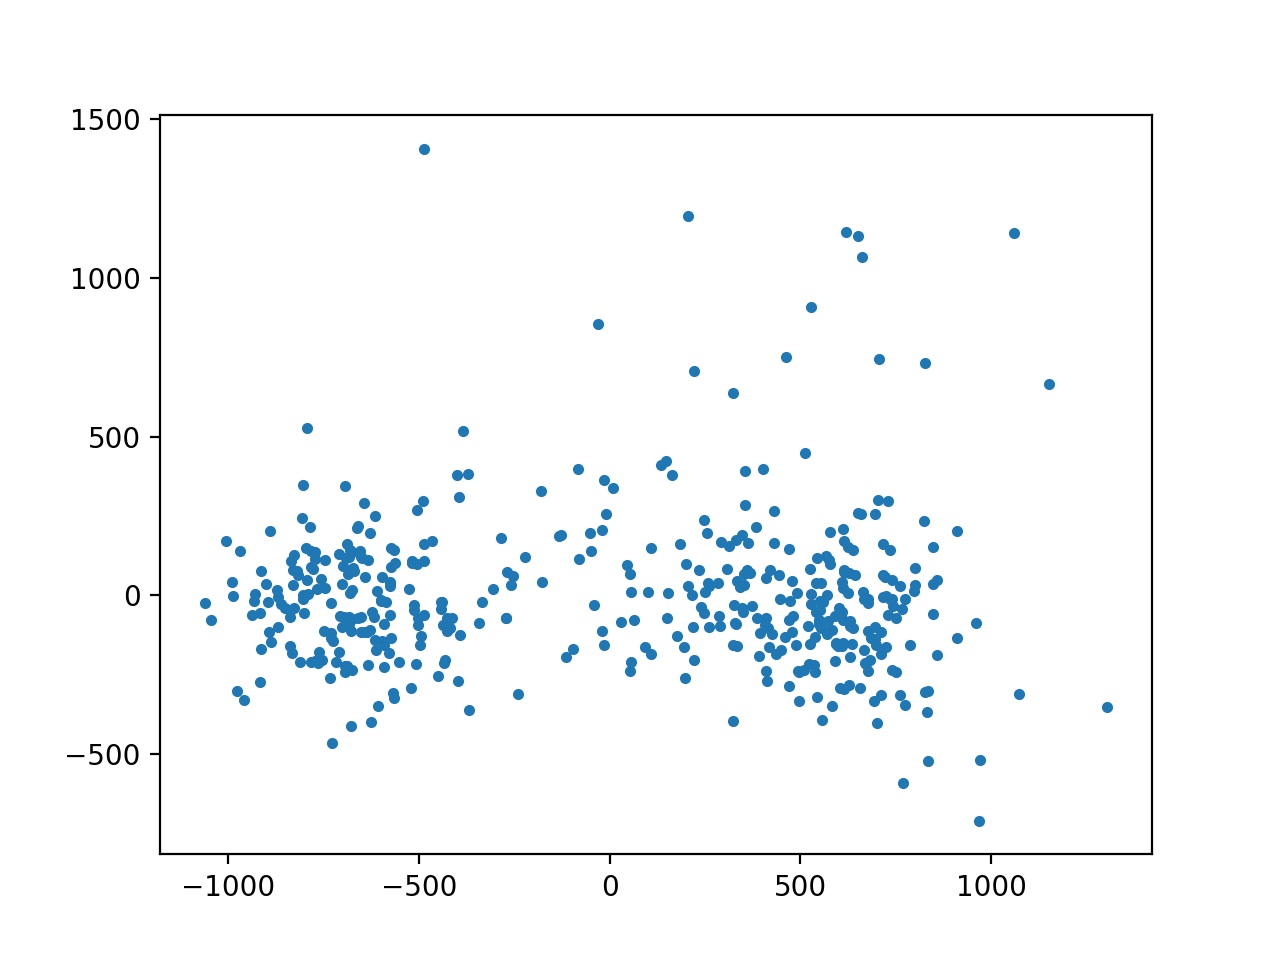

In [12]:
plt.figure()
plt.plot(x_pca[:,0], x_pca[:,1], '.')


## Choose number of kmeans clusters:

<IPython.core.display.Javascript object>


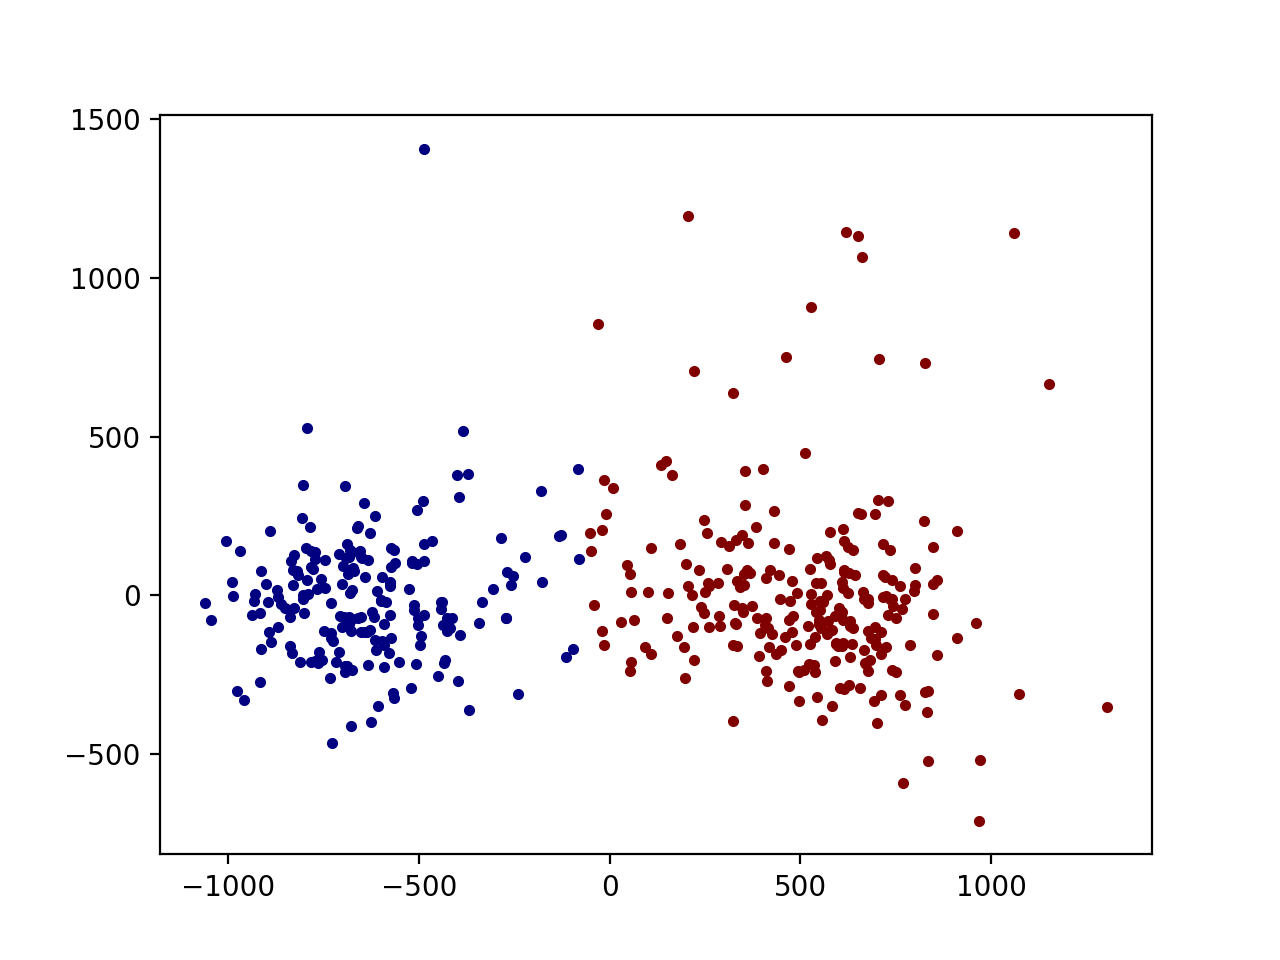

In [19]:
# cluster spikes
num_clusters = 2

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(x_pca)
labels = kmeans.predict(x_pca)
x = x_pca[np.where(labels == 0)]
x.shape

colors = plt.cm.jet(np.linspace(0,1,kmeans.n_clusters))
plt.figure()
for i in range(kmeans.n_clusters):
    x = np.squeeze(x_pca[np.where(labels == i), 0])
    y = np.squeeze(x_pca[np.where(labels == i), 1])
    plt.plot(x , y , '.', color = colors[i])
    


<IPython.core.display.Javascript object>


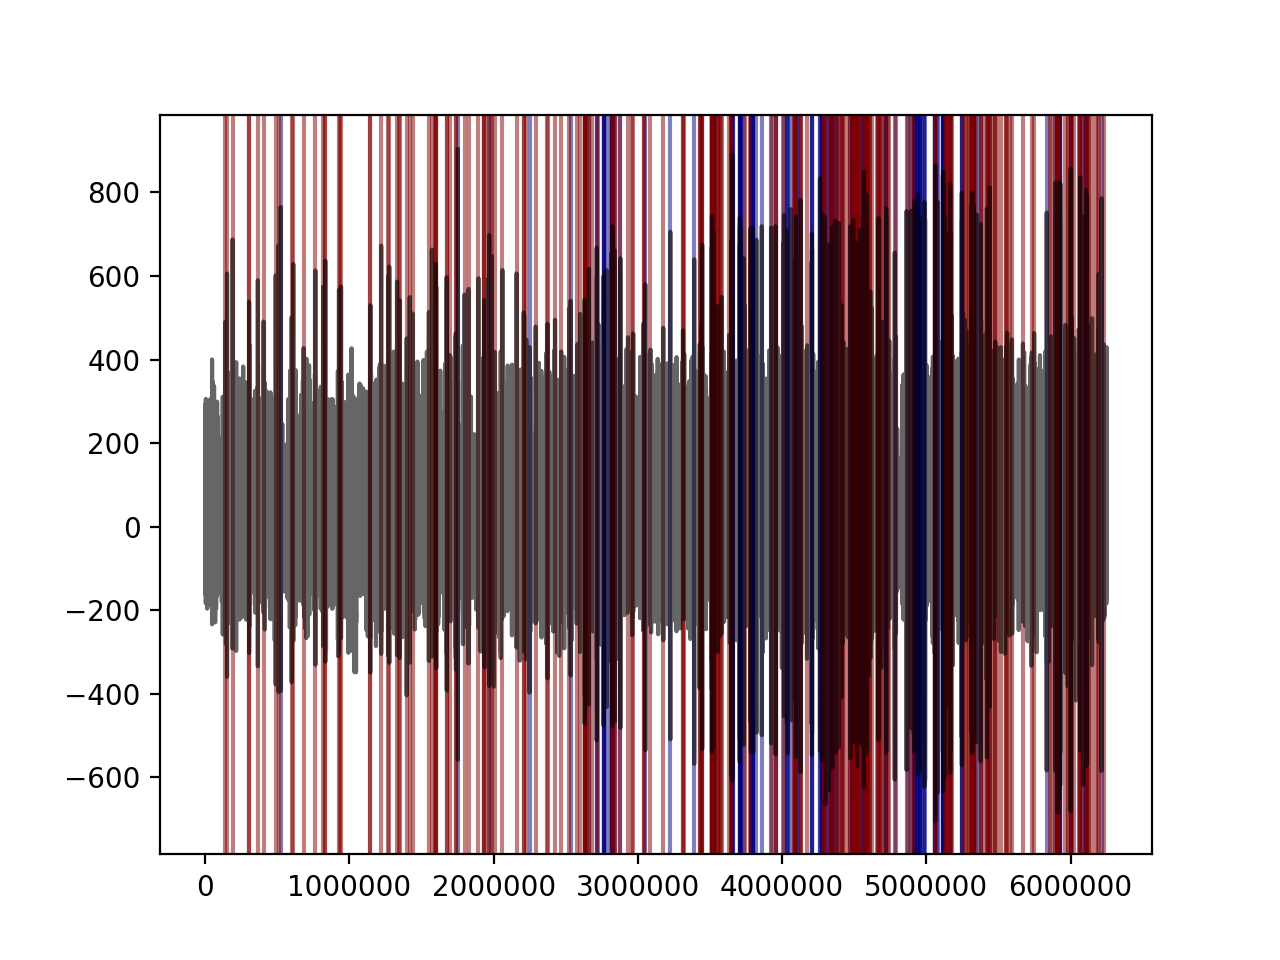

In [17]:
from kaveh.plots import axvlines
plt.figure()
plt.plot(ch, 'k', alpha = 0.6)
for i in range(kmeans.n_clusters):
    axvlines(plt.gca(), spike_indices[np.where(labels == i)], color = colors[i], alpha = 0.5)
    

## Save to .mat file

In [15]:
from scipy.io import savemat
scipy.io.savemat('/mnt/data/temp/test.mat', {'spike_indices': spike_indices, 'labels': labels, 'channel': ch})